# Statistics of Data Release 1 (DR1) targets with multiple spectra

Nov 2023

*Angela Berti (U.Utah), Ragadeepika Pucha (U.Arizona), Stephanie Juneau (NOIRLab), Anthony Kremin (Berkeley Lab), Jaime E. Forero-Romero (Uniandes), Farnik Nikakhtar (Yale) and DESI Data Team*

This notebook has been tested with the DESI 23.1 kernel.

### Table of Contents
* [Overview](#overview)
* [Imports](#imports)
* [Accessing the data](#data)
* [Catalog statistics by survey](#stats_survey)
  * [Unique targets in each survey](#counts_survey_total)
* [Primary spectra](#primary)
* [Catalog statistics by target type](#stats_target)
  * [DESI target masks](#masks_desi)
  * [Spectra by target type](#counts_target)
* [Redshift distributions by target type and survey](#redshift_dist)
* [Target counts by target type and survey](#counts_target_survey)
* [Targets with multiple spectra](#multispec)
  * [Multiple SPECTYPE classifications](#spectype_diff)
  * [Bright versus dark time spectra of the same target](#bright_dark)

<a class="anchor" id="overview"></a>
## Overview

This notebook demonstrates how to flag a unique set of the primary (i.e., best) spectrum for an object in the DR1 catalog, and apply some basic quality cuts. This notebook also provides examples of how break down the data in the combined catalog by target type (BGS, LRG, etc.), survey (main/special), and the number of spectra per target. Finally, it covers how to extract and plot different spectra of the same target.

<a class="anchor" id="imports"></a>
## Imports

In [1]:
import os
import numpy as np

import fitsio

from astropy.io import fits
from astropy.table import Table, vstack, join
from astropy.convolution import convolve, Gaussian1DKernel

import matplotlib
import matplotlib.pyplot as plt

#-- input/output functions related to DESI spectra
import desispec.io

plt.style.use("../mpl/desi.mplstyle")


<a class="anchor" id="data"></a>
## Accessing the data

The DESI Data Release 1 (DR1) includes spectra for ~17 million unique targets from Main survey observations taken from May 2021 through June 2022.

For the DR1 data, the spectra are divided by the `SURVEY` (main/special) they were observed in. The observing conditions (dark or bright), called as `PROGRAM` in the DESI terminology, is used to categorize the spectra further. 

TODO: mention switching to edr

In [2]:
# Release directory path

specprod = "guadalupe"    # Internal name for the DR1
specprod_dir = "/global/cfs/cdirs/desi/public/dr1/spectro/redux/guadalupe/"
print(specprod_dir)


/global/cfs/cdirs/desi/public/dr1/spectro/redux/guadalupe/


In [3]:
data = Table(fitsio.read(os.path.join(specprod_dir, "zcatalog", "zall-pix-{}.fits".format(specprod))) )

<a class="anchor" id="stats_survey"></a>

## Statistics of the combined catalog by survey

<a class="anchor" id="masks_survey"></a>

### Create masks to select each survey

TODO: Determine whether to retain `is_SV` cuts when all are zero, or only divide by main/special.

In [4]:
#-- SV1/2/3
is_sv1 = (data["SURVEY"].astype(str).data == "sv1")
is_sv2 = (data["SURVEY"].astype(str).data == "sv2")
is_sv3 = (data["SURVEY"].astype(str).data == "sv3")

#-- all SV data
is_sv = (is_sv1 | is_sv2 | is_sv3)

#-- commissioning data
is_cmx = (data["SURVEY"].astype(str).data == "cmx")

#-- main
is_main = (data["SURVEY"].astype(str).data == "main")

#-- special tiles
is_special = (data["SURVEY"].astype(str).data == "special")

<a class="anchor" id="counts_survey_total"></a>

### Identify the total number of unique targets observed in each survey, as well as in the combined catalog

Uncomment specific lines to print numbers for additional surveys.

In [5]:
#-- all unique targets in SV
targids_sv = np.unique(data["TARGETID"][is_sv])

print("Unique targets in SV:     {0:8}".format( len(targids_sv) ))

print("\nTotal unique targets in combined catalog: {}\n".format( len(np.unique(data["TARGETID"])) ))

print("Unique targets in SV1:    {0:8}".format( len(np.unique(data["TARGETID"][is_sv1])) ))
print("Unique targets in SV2:    {0:8}".format( len(np.unique(data["TARGETID"][is_sv2])) ))
print("Unique targets in SV3:    {0:8}".format( len(np.unique(data["TARGETID"][is_sv3])) ))

print("\nUnique targets in CMX:    {0:8}".format( len(np.unique(data["TARGETID"][is_cmx])) ))

print("\nUnique targets in Main:{0:8}".format( len(np.unique(data["TARGETID"][is_main])) ))

print("\nUnique targets in Special:{0:8}".format( len(np.unique(data["TARGETID"][is_special])) ))

Unique targets in SV:            0

Total unique targets in combined catalog: 3183266

Unique targets in SV1:           0
Unique targets in SV2:           0
Unique targets in SV3:           0

Unique targets in CMX:           0

Unique targets in Main: 3167209

Unique targets in Special:   24412


<a class="anchor" id="primary"></a>

## Primary spectra

<a class="anchor" id="counts_survey_unique"></a>
### How many primary spectra are in the surveys?
Uncomment specific lines to print numbers for other surveys.

TODO: switching to edr?

In [6]:
print("Primary spectra in...\n")
# print("  SV:              {0:8}".format( np.count_nonzero(is_sv & data["SV_PRIMARY"])))
# print("  combined catalog:{0:8}\n".format( np.count_nonzero(data["ZCAT_PRIMARY"])))

# print("  SV1:    {0:8}".format( np.count_nonzero(is_sv1 & data["SV_PRIMARY"]) ))
# print("  SV2:    {0:8}".format( np.count_nonzero(is_sv2 & data["SV_PRIMARY"]) ))
# print("  SV3:    {0:8}\n".format( np.count_nonzero(is_sv3 & data["SV_PRIMARY"]) ))

# print("  CMX:    {0:8}\n".format( np.count_nonzero(is_cmx & data["ZCAT_PRIMARY"]) ))

print("  Main:{0:8}".format( np.count_nonzero(is_main & data["ZCAT_PRIMARY"]) ))

print("  Special:{0:8}".format( np.count_nonzero(is_special & data["ZCAT_PRIMARY"]) ))

Primary spectra in...

  Main: 3159084
  Special:   24182



<a class="anchor" id="stats_target"></a>
## Statistics of the combined catalog by target type

<a class="anchor" id="masks_desi"></a>
### DESI target masks

TODO: double check for the main survey mask.

Targeting bits are encoded in `desi_mask`, which can be imported from `desitarget.targetmask`. While not universally true, for the purposes of this notebook it doesn"t matter which `desi_mask` is used; any of the four import options below will give the same results.


In [10]:
from desitarget.targetmask import desi_mask, bgs_mask, scnd_mask
# from desitarget.sv1.sv1_targetmask import desi_mask, bgs_mask, scnd_mask  # SV1
# from desitarget.sv2.sv2_targetmask import desi_mask, bgs_mask, scnd_mask  # SV2
# from desitarget.sv3.sv3_targetmask import desi_mask, bgs_mask, scnd_mask  # SV3

In [11]:
#-- select the target mask for each type of target (BGS, LRG, ELG, QSO, etc.)

bgs_tgtmask  = desi_mask["BGS_ANY"]
lrg_tgtmask  = desi_mask["LRG"]
elg_tgtmask  = desi_mask["ELG"]
qso_tgtmask  = desi_mask["QSO"]
mws_tgtmask  = desi_mask["MWS_ANY"]
scnd_tgtmask = desi_mask["SCND_ANY"]


<a class="anchor" id="masks_target"></a>

### Define masks to select all targets of each type from the combined catalog

Information about DESI target selection is stored in the `DESI_TARGET` column. The masks below select *all* targets of a given type.


In [12]:
desi_target = data["DESI_TARGET"]

#-- all BGS targets
is_bgs = (desi_target & bgs_tgtmask != 0)

#-- all LRG targets
is_lrg = (desi_target & lrg_tgtmask != 0)

#-- all ELG targets
is_elg = (desi_target & elg_tgtmask != 0)

#-- all QSO targets
is_qso = (desi_target & qso_tgtmask != 0) 

#-- all Milky Way targets
is_mws = (desi_target & mws_tgtmask != 0) 

#-- all secondary targets
is_scnd = (desi_target & scnd_tgtmask != 0)

<a class="anchor" id="counts_target"></a>
### Plot the total number of spectra of each target type


In [13]:
#-- total number of spectra by target type
n_bgs  = np.count_nonzero(is_bgs)
n_lrg  = np.count_nonzero(is_lrg)
n_elg  = np.count_nonzero(is_elg)
n_qso  = np.count_nonzero(is_qso)
n_mws  = np.count_nonzero(is_mws)
n_scnd = np.count_nonzero(is_scnd)

counts = [n_bgs, n_lrg, n_elg, n_qso, n_mws, n_scnd]

#-- number of primary spectra by target type
is_primary = data["ZCAT_PRIMARY"]

n_bgs_prim  = np.count_nonzero(is_bgs & is_primary)
n_lrg_prim  = np.count_nonzero(is_lrg & is_primary)
n_elg_prim  = np.count_nonzero(is_elg & is_primary)
n_qso_prim  = np.count_nonzero(is_qso & is_primary)
n_mws_prim  = np.count_nonzero(is_mws & is_primary)
n_scnd_prim = np.count_nonzero(is_scnd & is_primary)

counts_prim = [n_bgs_prim, n_lrg_prim, n_elg_prim, n_qso_prim, n_mws_prim, n_scnd_prim]


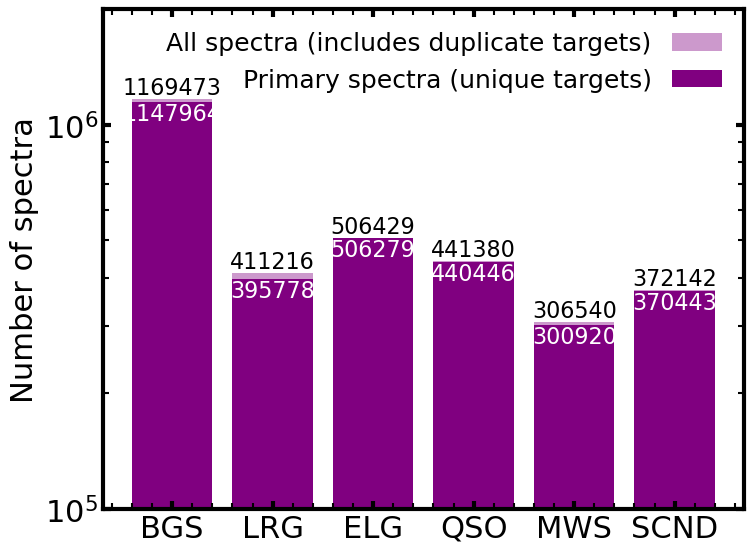

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

targets = ["BGS", "LRG", "ELG", "QSO", "MWS", "SCND"]

ax.bar(targets, counts, color="purple", alpha=0.4, label="All spectra (includes duplicate targets)")
ax.bar(targets, counts_prim, color="purple", alpha=1, label="Primary spectra (unique targets)")
ax.set_ylabel("Number of spectra")
ax.semilogy()
ax.set_ylim(1e5, 2e6)

for i in range(len(targets)):
    ax.text(targets[i], counts[i], counts[i], ha="center", va="bottom", fontsize=16)
    ax.text(targets[i], counts_prim[i], counts_prim[i], ha="center", va="top", fontsize=16, color="white")

plt.legend(fontsize=18, frameon=False, markerfirst=False)
plt.tight_layout()
plt.show()


<a class="anchor" id="redshift_dist"></a>

## Redshift distributions by target type and survey

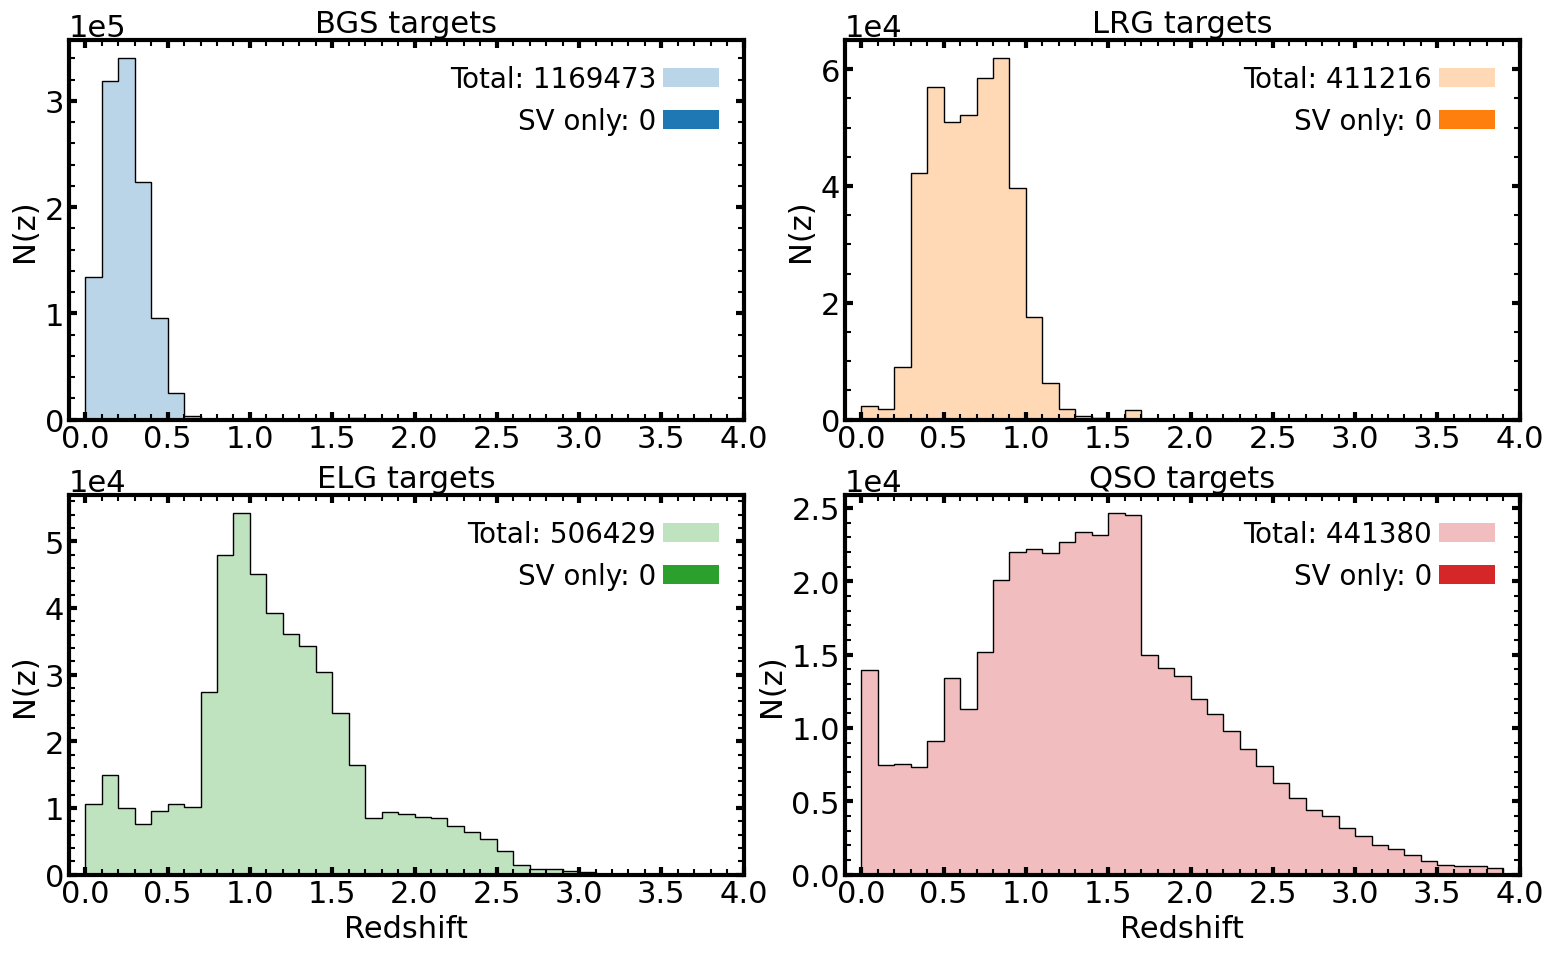

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(16,10))

bins = np.arange(0,4,0.1)

type_masks = (is_bgs, is_lrg, is_elg, is_qso)
colors     = ("C0","C1","C2","C3")

for ax,type_mask,name,color in zip(np.concatenate(axes), type_masks, targets[:-2], colors):
    kwargs = dict(color=color, bins=bins)
    
    ax.hist(data["Z"][type_mask], **kwargs, alpha=0.3, label=f"Total: {len(data[type_mask])}")
    ax.hist(data["Z"][type_mask], bins=bins, histtype="step", color="black")
    
    mask = type_mask & is_sv
    ax.hist(data["Z"][mask], **kwargs, label=f"SV only: {len(data[mask])}")
    ax.hist(data["Z"][mask], bins=bins, histtype="step", color="black")
    
    ax.legend(fontsize=20, markerfirst=False, handletextpad=0.25, frameon=False)
    ax.set_title(f"{name} targets", fontsize=22)

for ax in axes[-1]:
    ax.set_xlabel("Redshift")

for ax in np.concatenate(axes):
    ax.set_xlim(-0.1,4.0)
    ax.set_xticks(np.arange(0,4.1,0.5))
    ax.set_ylabel("N(z)")
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

plt.tight_layout()
plt.subplots_adjust(hspace=0.2, wspace=0.15)

### Target class versus Redrock spectral type

The above plot shows $N(z)$ for all *targets* of a given type, but [Redrock](https://github.com/desihub/redrock) will not necessarily classify all spectra as having the same spectral type as their original target class. For example, the following plot breaks down QSO targets by their Redrock spectral type (`GALAXY`, `QSO`, or `STAR`), contained in the `SPECTYPE` column.

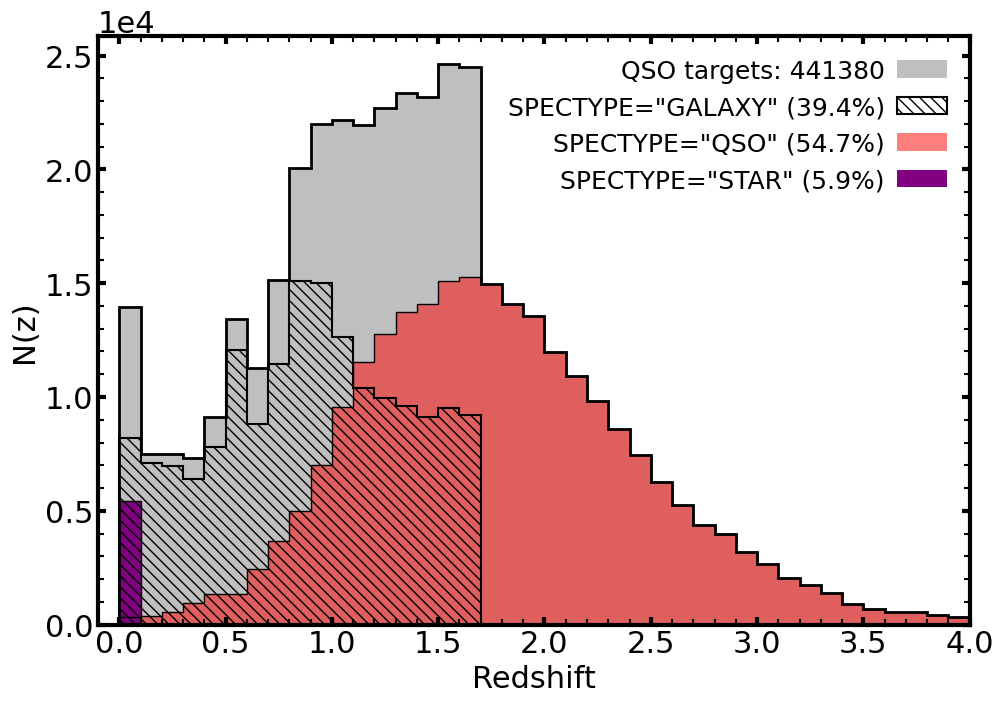

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(10.5,7.5))

bins = np.arange(0,4.1,0.1)

#-- all QSO targets
ax.hist(data["Z"][is_qso], bins=bins, color="gray", alpha=0.5, label=f"QSO targets: {n_qso}")

#-- QSO targets classified as galaxies
spec_gal = is_qso & (data["SPECTYPE"]=="GALAXY")
ax.hist(data["Z"][spec_gal], bins=bins, histtype="step", hatch="\\\\\\", color="k", lw=1.5,
        label=f"SPECTYPE=\"GALAXY\" ({100*len(data[spec_gal])/n_qso:.1f}%)")

#-- QSO targets classified as quasars
spec_qso = is_qso & (data["SPECTYPE"]=="QSO")
ax.hist(data["Z"][spec_qso], bins=bins, color="red", alpha=0.5,
        label=f"SPECTYPE=\"QSO\" ({100*len(data[spec_qso])/n_qso:.1f}%)")
ax.hist(data["Z"][spec_qso], bins=bins, histtype="step", color="k", lw=1)

#-- QSO targets classified as stars
spec_star = is_qso & (data["SPECTYPE"]=="STAR")
ax.hist(data["Z"][spec_star], bins=bins, color="purple",
        label=f"SPECTYPE=\"STAR\" ({100*len(data[spec_star])/n_qso:.1f}%)")
ax.hist(data["Z"][spec_star], bins=bins, histtype="step", color="k", lw=1)

ax.hist(data["Z"][is_qso], bins=bins, histtype="step", color="black", lw=2)

ax.legend(fontsize=18, markerfirst=False, handletextpad=0.5, frameon=False)

ax.set_xlabel("Redshift")
ax.set_xlim(-0.1,4.0)
ax.set_xticks(np.arange(0,4.1,0.5))
ax.set_ylabel("N(z)")
ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

plt.tight_layout()


<a class="anchor" id="multispec"></a>
## Targets with multiple spectra

As shown in the plot below, the vast majority of targets in the combined catalog have only one spectrum. About 3% of targets have two spectra, and only a few thousand have three, four, or five (the maximum).

Note that these numbers will be slightly different depending on whether the bad fiber quality cut has been applied to the combined catalog. If spectra associated with bad fibers are removed *after* `ZCAT_NSPEC` has been computed and added to the catalog, then some targets with `ZCAT_NSPEC` $\,=x$ (where $x>1$) may appear in the catalog fewer than $x$ times.


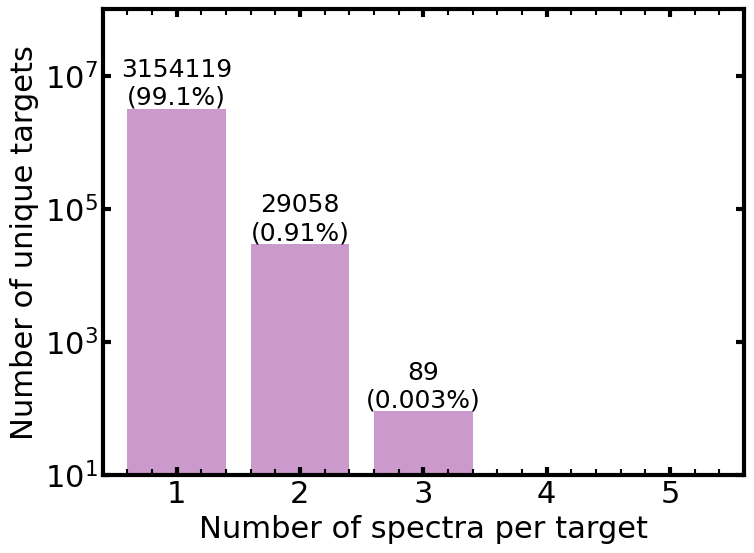

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

freq, hist = np.array(np.unique(data["ZCAT_NSPEC"], return_counts=True))
hist  = ( hist / np.arange(1,np.max(freq)+1) ).astype(int)
n_tot = sum(hist)
ax.bar(freq, hist, color="purple", alpha=0.4)

ax.set_xlabel("Number of spectra per target")
ax.set_xlim(0.4,5.6)
ax.set_ylabel("Number of unique targets")
ax.set_ylim(1e1,1e8)
ax.semilogy()

round_to = [1,2,3]
pct = [f"{np.round( 100*hist[i]/n_tot, round_to[i] )}" for i in range(len(round_to))]

for i in range(len(round_to)):
    ax.text(freq[i], hist[i], f"{hist[i]}\n({pct[i]}%)", ha="center", va="bottom", fontsize=18)

plt.tight_layout()
plt.show()


#### Below we'll look more closely at the targets with five spectra


In [42]:
#-- get all targets with NSPEC=5
t_fivespec = data[data["ZCAT_NSPEC"]==3]

#-- unique TARGETID of each object with five spectra
targids = np.unique(t_fivespec["TARGETID"])

print("\tTARGETID\t\tSPECTYPE of all 5 spectra")
for i,tid in enumerate(targids):
    these_spec = t_fivespec[t_fivespec["TARGETID"]==tid]
    spectype   = these_spec["SPECTYPE"].data.astype(str)
    print("{0:3}\t{1}\t{2}".format(i+1, tid, spectype))

	TARGETID		SPECTYPE of all 5 spectra
  1	39632981387640922	['STAR' 'STAR' 'STAR']
  2	39632986320142953	['STAR' 'STAR' 'STAR']
  3	39633001058927341	['STAR' 'STAR' 'STAR']
  4	39633001063124147	['STAR' 'STAR' 'STAR']
  5	39633001067318201	['STAR' 'STAR' 'STAR']
  6	39633001075704188	['STAR' 'STAR' 'STAR']
  7	39633001117647014	['STAR' 'STAR' 'STAR']
  8	39633005949485191	['STAR' 'STAR' 'STAR']
  9	39633005966263137	['STAR' 'STAR' 'STAR']
 10	39633010827461373	['STAR' 'STAR' 'STAR']
 11	39633010835851861	['STAR' 'STAR' 'STAR']
 12	39633015692854002	['STAR' 'STAR' 'STAR']
 13	39633015726408545	['STAR' 'STAR' 'STAR']
 14	39633015730602307	['STAR' 'STAR' 'STAR']
 15	39633025390086715	['STAR' 'STAR' 'STAR']
 16	39633272107436397	['GALAXY' 'GALAXY' 'GALAXY']
 17	39633272111633573	['GALAXY' 'GALAXY' 'GALAXY']
 18	39633272115823540	['GALAXY' 'GALAXY' 'GALAXY']
 19	39633272120021475	['GALAXY' 'GALAXY' 'GALAXY']
 20	39633272124212321	['GALAXY' 'GALAXY' 'GALAXY']
 21	39633272124213232	['GALAXY' '

Most of the targets with five spectra have been flagged as stars by Redrock. One object (12 above) has four spectra flagged as a star, but the fifth classification is a galaxy. Let's look more closely at this object.

<a class="anchor" id="spectype_diff"></a>
### Targets with multiple `SPECTYPE` classifications


In [52]:
#-- get the data for all observations of this TARGETID
special_ID = 616094028173148822
these_spec = t_fivespec[ t_fivespec["TARGETID"]==special_ID]

#-- get the SURVEY, PROGRAM, SPECTYPE, and redshift values for each of the five spectra of this object
survey   = these_spec["SURVEY"].data.astype(str)
program  = these_spec["PROGRAM"].data.astype(str)
redshift = np.round(these_spec["Z"].data,5)
spectype = these_spec["SPECTYPE"].data.astype(str)

print("\tSURVEY  PROGRAM  SPECTYPE  REDSHIFT")
for i in range(3):
    print("{0:1}/3\t{1:7} {2:8} {3:8} {4:8}".format(i+1, survey[i], program[i], spectype[i], redshift[i]))


	SURVEY  PROGRAM  SPECTYPE  REDSHIFT
1/3	main    bright   GALAXY    1.28735
2/3	main    dark     STAR     -0.00167
3/3	special bright   STAR     -0.00026


The four spectra classified as `STAR` have $z\sim0$, while the redshift of the spectrum with the `GALAXY` classification is $z\sim0.316$. Let's plot several of these spectra to invesitgate the different in `SPECTYPE` classification and redshift measurement.

The `get_spec_data` function defined below is a convenience function to load the relevant data for plotting the spectrum for a given `TARGETID`, `SURVEY`, and `PROGRAM`. We will use it to load different spectra of the same object.

In [54]:
def get_spec_data(tid, survey=None, program=None):
    #-- the index of the specific target can be uniquely determined with the combination of TARGETID, SURVEY, and PROGRAM
    idx = np.where( (data["TARGETID"]==tid) & (data["SURVEY"]==survey) & (data["PROGRAM"]==program) )[0][0]

    #-- healpix values are integers but are converted here into a string for easier access to the file path
    hpx = data["HEALPIX"].astype(str)

    specprod = "guadalupe"

    specprod_dir = f"/global/cfs/cdirs/desi/spectro/redux/{specprod}"
    target_dir   = f"{specprod_dir}/healpix/{survey}/{program}/{hpx[idx][:-2]}/{hpx[idx]}"
    coadd_fname  = f"coadd-{survey}-{program}-{hpx[idx]}.fits"

    #-- read in the spectra with desispec
    coadd_obj  = desispec.io.read_spectra(f"{target_dir}/{coadd_fname}")
    coadd_tgts = coadd_obj.target_ids().data

    #-- select the spectrum of  targetid
    row = ( coadd_tgts==data["TARGETID"][idx] )
    coadd_spec = coadd_obj[row]

    return coadd_spec


In [57]:
#-- get the third, fourth, and fifth spectra for this object 

tid = special_ID #-- TARGETID

#-- 1/3 above; SPECTYPE = STAR
main_bright_gal = get_spec_data(tid, survey="main", program="bright")

#-- 2/3 above; SPECTYPE = STAR
main_dark_star = get_spec_data(tid, survey="main", program="dark")


INFO:spectra.py:291:read_spectra: iotime 0.321 sec to read coadd-main-bright-15243.fits at 2023-12-08T15:00:02.740257
INFO:spectra.py:291:read_spectra: iotime 0.855 sec to read coadd-main-dark-15243.fits at 2023-12-08T15:00:05.349939


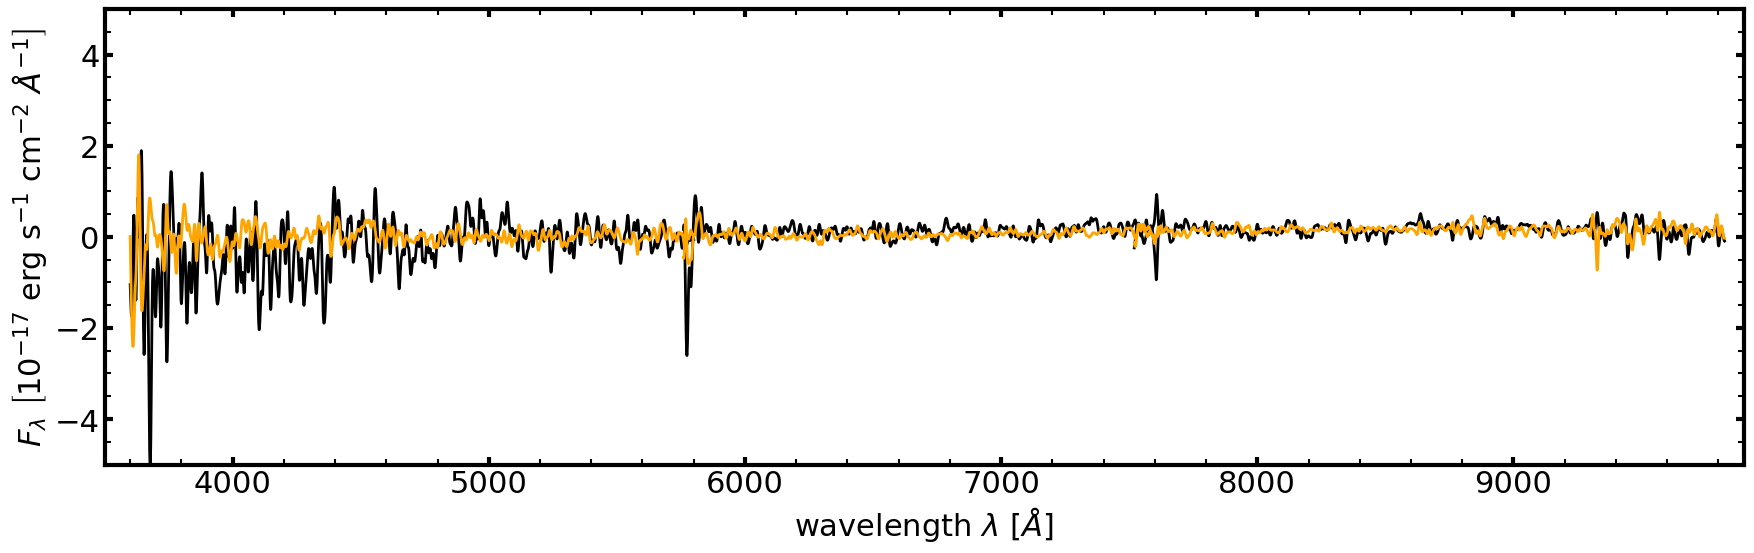

In [63]:
#-- plot the spectra

fig, ax = plt.subplots(1, 1, figsize=(18,6))

ax.set_xlim(3500, 9900)
ax.set_xlabel(r"wavelength $\lambda\ \left[ \AA \right]$")
ax.set_ylim(-5, 5)
ax.set_ylabel(r"$F_{\lambda}\ \left[ 10^{-17}\ {\rm erg\ s}^{-1}\ {\rm cm}^{-2}\ \AA^{-1} \right]$")

spectra = ( main_bright_gal, main_dark_star )
zwarn   = (0,0,1570)
coaddfs = (0,0,0)
for PROG,ST,spec,color,zw,cfs in zip( ("BRIGHT", "DARK"), ("GALAXY","STAR"), spectra, ("k","orange"), zwarn, coaddfs ):
    for band in ("b","r","z"):
        label = f"PROG={PROG} | SPECTYPE={ST} | COADD_FIBERSTATUS={cfs} | ZWARN={zw}" if band=="b" else ""
        ax.plot(spec.wave[band], convolve(spec.flux[band][0], Gaussian1DKernel(5)), label=label, color=color, lw=2)

# ax.text(3600, 39, f"TARGETID = {tid}", ha="left", va="bottom")
# ax.legend(markerfirst=False, fontsize=18, handletextpad=0.5, frameon=False)

#-- annotations
# ax.text(5800, 10, r"$\leftarrow$" + "arm overlap (not absorption)" + r"$\rightarrow$", ha="left", va="bottom", fontsize=19, color="red", rotation=350)
# ax.text(4800, 34, r"$\downarrow$", ha="left", va="bottom", fontsize=24, color="red")
# ax.text(6500, 23, r"$\downarrow$", ha="left", va="bottom", fontsize=24, color="red")
# ax.text(4920, 36, "absorption line", ha="left", va="bottom", fontsize=19, color="red")
# ax.text(6620, 25, "absorption line", ha="left", va="bottom", fontsize=19, color="red")

plt.tight_layout()

The SV1 dark time spectrum (black line) is clearly a stellar spectrum and correctly classified by Redrock, while the shape of the SV3 "other" program spectrum (orange line) is somewhat ambiguous. It is not surpising that this spectrum was misclassified as a galaxy. The SV3 bright time spectrum (magenta line) obviously has no flux data, and it is not immediately clear why it was classified as a stellar spectrum. Below we'll look at additional columns for these spectra.


In [64]:
#-- show all data columns for the five spectra for this target

t_fivespec[ t_fivespec["TARGETID"]==tid ].show_in_notebook()


idx,TARGETID,SURVEY,PROGRAM,HEALPIX,SPGRPVAL,Z,ZERR,ZWARN,CHI2,COEFF,NPIXELS,SPECTYPE,SUBTYPE,NCOEFF,DELTACHI2,COADD_FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,REF_EPOCH,FA_TARGET,FA_TYPE,OBJTYPE,SUBPRIORITY,OBSCONDITIONS,RELEASE,BRICKNAME,BRICKID,BRICK_OBJID,MORPHTYPE,EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,MASKBITS,SERSIC,SHAPE_R,SHAPE_E1,SHAPE_E2,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_RP_MEAN_MAG,PARALLAX,PHOTSYS,PRIORITY_INIT,NUMOBS_INIT,DESI_TARGET,BGS_TARGET,MWS_TARGET,SCND_TARGET,PLATE_RA,PLATE_DEC,COADD_NUMEXP,COADD_EXPTIME,COADD_NUMNIGHT,COADD_NUMTILE,MEAN_DELTA_X,RMS_DELTA_X,MEAN_DELTA_Y,RMS_DELTA_Y,MEAN_FIBER_RA,STD_FIBER_RA,MEAN_FIBER_DEC,STD_FIBER_DEC,MEAN_PSF_TO_FIBER_SPECFLUX,TSNR2_GPBDARK_B,TSNR2_ELG_B,TSNR2_GPBBRIGHT_B,TSNR2_LYA_B,TSNR2_BGS_B,TSNR2_GPBBACKUP_B,TSNR2_QSO_B,TSNR2_LRG_B,TSNR2_GPBDARK_R,TSNR2_ELG_R,TSNR2_GPBBRIGHT_R,TSNR2_LYA_R,TSNR2_BGS_R,TSNR2_GPBBACKUP_R,TSNR2_QSO_R,TSNR2_LRG_R,TSNR2_GPBDARK_Z,TSNR2_ELG_Z,TSNR2_GPBBRIGHT_Z,TSNR2_LYA_Z,TSNR2_BGS_Z,TSNR2_GPBBACKUP_Z,TSNR2_QSO_Z,TSNR2_LRG_Z,TSNR2_GPBDARK,TSNR2_ELG,TSNR2_GPBBRIGHT,TSNR2_LYA,TSNR2_BGS,TSNR2_GPBBACKUP,TSNR2_QSO,TSNR2_LRG,MAIN_NSPEC,MAIN_PRIMARY,ZCAT_NSPEC,ZCAT_PRIMARY
0,616094028173148822,main,bright,15243,15243,1.2873464919843587,7.086605572088518e-05,516,7358.219855308533,53.109931700110906 .. -19.222347358488157,7925,GALAXY,,10,2.802834540605545,0,278.67770199893033,51.75732018238678,0.0,0.0,0.0,68719476736,8,BAD,0.9785819462536299,63,9011,2788p517,590982,662,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.03738232,0.025953172,0.043862082,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,,0.0,0.0,0.0,0.0,,0,0,68719476736,0,0,0,278.67770199893033,51.75732018238678,2,667.0468,2,1,0.0035,0.008276473,-0.004,0.004,278.6777242849812,0.281132,51.75733520015747,0.00081533735,0.79258704,40.56939,0.013178812,7.839367,8.592368,78.79489,66.37773,0.34020874,0.16280109,2661.5908,5.2498026,504.6636,0.011457589,613.53357,4011.892,1.6969862,7.94271,3.8670028e-06,22.435251,7.4548984e-07,0.0,1053.1404,6.269329e-06,4.5843215,10.526258,2702.1602,27.698233,512.503,8.603826,1745.4689,4078.2698,6.621516,18.63177,2,False,3,False
1,616094028173148822,main,dark,15243,15243,-0.0016676186891200423,6.673704966492577e-05,516,7694.767680748605,-30.383398241660313 .. 0.0,7902,STAR,M,5,0.977389127708193,0,278.67770199893033,51.75732018238678,0.0,0.0,0.0,68719476736,8,BAD,0.9785819462536299,63,9011,2788p517,590982,662,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.03738232,0.025953172,0.043862082,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,,0.0,0.0,0.0,0.0,,0,0,68719476736,0,0,0,278.67770199893033,51.75732018238678,1,874.0811,1,1,0.015,0.015,-0.013,0.013,278.6777977921973,0.0,51.75736888056223,0.0,0.7940537,191.94531,0.09513391,34.315422,71.07014,502.64594,238.55614,2.535667,0.9780841,14270.692,29.937243,2375.4424,0.05286916,2785.396,14060.074,9.461025,44.03478,1.7324166e-05,76.94437,3.0866015e-06,0.0,3716.3994,2.1495169e-05,16.996185,38.530533,14462.638,106.976746,2409.7578,71.12301,7004.4414,14298.63,28.992878,83.543396,2,True,3,False
2,616094028173148822,special,bright,15243,15243,-0.0002560816360239431,1.2251343288058623e-05,512,11037.831723786196,147.23438690882136 .. 0.0,7929,STAR,K,5,1561.0754637948667,0,278.67770199893033,51.75732018238678,0.0,0.0,0.0,68719476736,8,BAD,0.9785819462536299,63,9011,2788p517,590982,662,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.03738232,0.025953172,0.043862082,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,,0.0,0.0,0.0,0.0,,0,0,68719476736,0,0,0,278.67770199893033,51.75732018238678,16,15914.691,6,1,0.0044375,0.005760859,-0.00475,0.007228416,278.67773027634286,0.13612136,51.75733800744974,0.07386679,0.7925849,321.2821,0.1568433,61.809654,108.05938,905.86487,494.65875,3.9615922,1.654778,26294.107,58.277935,4867.3154,0.087648675,5593.0845,34956.242,16.996578,85.23466,3.5383036e-05,170.35593,6.74891e-0

Looking at all the columns for these five spectra, we can see that all five have `COADD_FIBERSTATUS=0` (i.e., no bad fiber warning). However, the spectrum with no flux (4/5) has `ZWARN=1570`, while the other (good) spectra all have `ZWARN=0`. Scroll to the final column (`ZCAT_PRIMARY`) and we'll see that the third spectra (black line in the above plot) is the primary spectrum for this target.

<a class="anchor" id="bright_dark"></a>
### `BRIGHT` versus `DARK` program spectra of the same target

Now we'll look more closely at the `SURVEY`, `PROGRAM`, and redshift values of 34 targets with five spectra.

In [66]:
survey

array(['main', 'main', 'special'], dtype='<U7')

In [67]:
for tid in targids[:34]:
    these_spec = t_fivespec[t_fivespec["TARGETID"]==tid]
    survey   = these_spec["SURVEY"].data.astype(str)
    program  = these_spec["PROGRAM"].data.astype(str)
    redshift = these_spec["Z"].data
    spectype = these_spec["SPECTYPE"].data.astype(str)

    print(f"TARGETID = {tid}")
    print("    Survey  \t{0}\t{1}\t{2}".format(*survey))
    print("    Program \t{0}\t{1}\t{2}".format(*program))
    print("    Redshift\t{0:.4f}\t{1:.4f}\t{2:.4f}".format(*redshift))
    print("    Spectype \t{0}\t{1}\t{2}\n".format(*spectype))

TARGETID = 39632981387640922
    Survey  	main	main	special
    Program 	bright	dark	bright
    Redshift	-0.0007	-0.0007	-0.0007
    Spectype 	STAR	STAR	STAR

TARGETID = 39632986320142953
    Survey  	main	main	special
    Program 	bright	dark	bright
    Redshift	0.0001	0.0001	0.0001
    Spectype 	STAR	STAR	STAR

TARGETID = 39633001058927341
    Survey  	main	main	special
    Program 	bright	dark	bright
    Redshift	-0.0002	-0.0002	-0.0002
    Spectype 	STAR	STAR	STAR

TARGETID = 39633001063124147
    Survey  	main	main	special
    Program 	bright	dark	bright
    Redshift	-0.0007	-0.0007	-0.0007
    Spectype 	STAR	STAR	STAR

TARGETID = 39633001067318201
    Survey  	main	main	special
    Program 	bright	dark	bright
    Redshift	0.0002	0.0001	0.0001
    Spectype 	STAR	STAR	STAR

TARGETID = 39633001075704188
    Survey  	main	main	special
    Program 	bright	dark	bright
    Redshift	-0.0008	-0.0008	-0.0008
    Spectype 	STAR	STAR	STAR

TARGETID = 39633001117647014
    Survey  	main	main	

Each of these targets was observed three times during SV1 and twice during SV3 (once each during the bright and dark programs). 

Below we compare the dark and bright time spectra of this object from SV3. The top panel shows the smoothed bright time spectrum in magenta against the smoothed dark time spectrum in black. The middle and bottom panels show the bright and dark time spectra, respectively, smoothed in black, as well as the flux from each arm (*B*, *R*, and *Z*) shown in blue, green, and red. As expected, the bright time spectrum is clearly nosier than the dark time. 

In [69]:
#-- get two spectra for this object (first of the 34 galaxies with five spectra)

tid = targids[0] #-- TARGETID 

#-- get the DARK TIME spectrum
spec_dark = get_spec_data(tid, survey="main", program="dark")

#-- get the BRIGHT TIME spectrum
spec_bright = get_spec_data(tid, survey="main", program="bright")


INFO:spectra.py:291:read_spectra: iotime 0.796 sec to read coadd-main-dark-9151.fits at 2023-12-08T17:44:32.931500
INFO:spectra.py:291:read_spectra: iotime 0.675 sec to read coadd-main-bright-9151.fits at 2023-12-08T17:44:35.254025


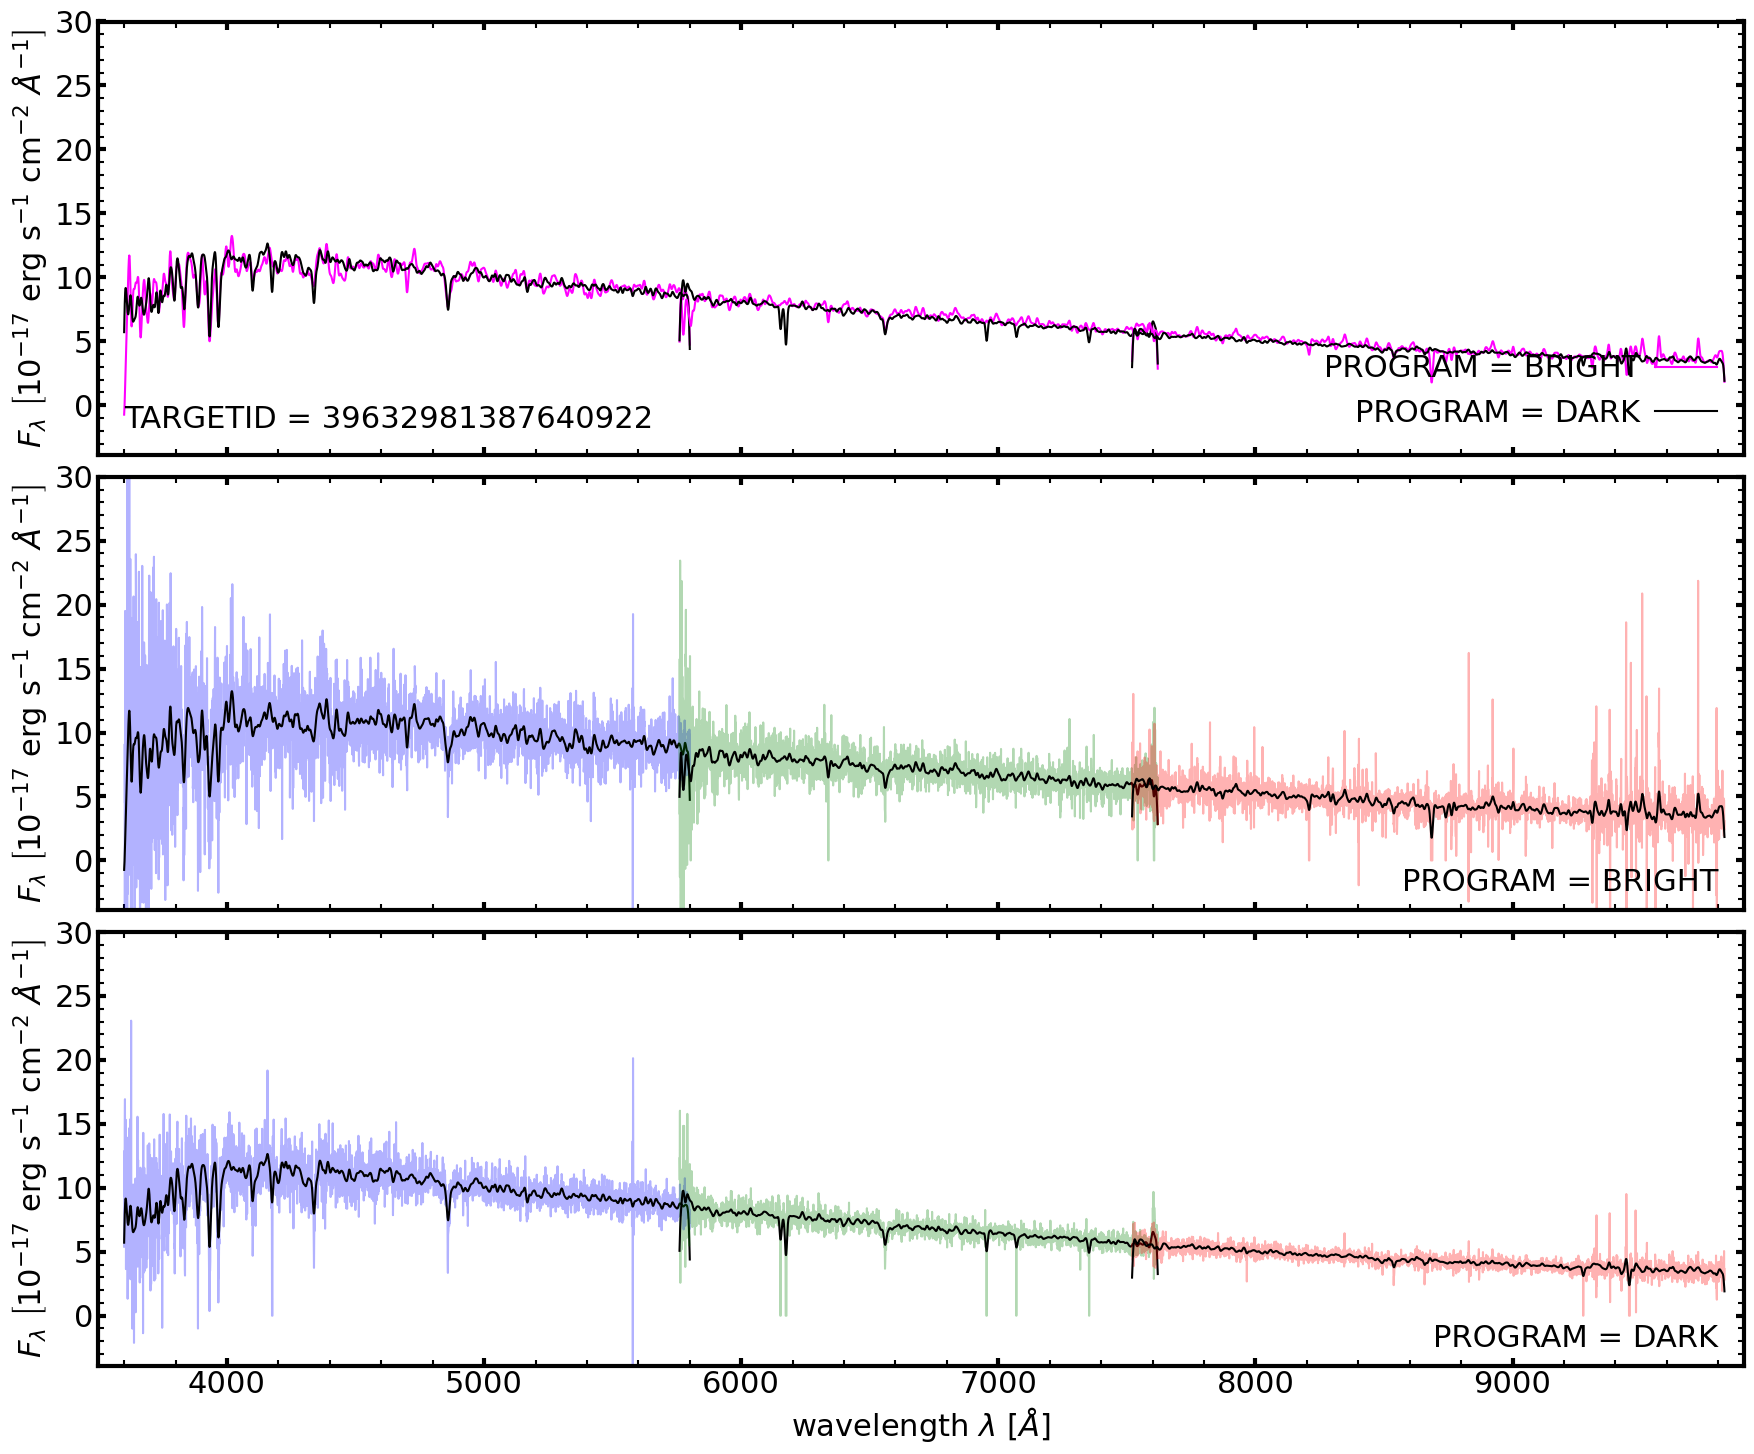

In [70]:
#-- plot the spectra

fig, axes = plt.subplots(3, 1, figsize=(18,15), sharex=True, sharey=True)

for ax in axes:
    ax.set_xlim(3500, 9900)
    ax.set_ylim(-3.9, 30)  #-- change depending on specific spectrum
    ax.set_ylabel(r"$F_{\lambda}\ \left[ 10^{-17}\ {\rm erg\ s}^{-1}\ {\rm cm}^{-2}\ \AA^{-1} \right]$")

axes[-1].set_xlabel(r"wavelength $\lambda\ \left[ \AA \right]$")

#-- plot the BRIGHT TIME and DARK TIME spectra (both smoothed) on the same axis
for band in ("b","r","z"):
    if band=="z":
        label_bright = "PROGRAM = BRIGHT"
        label_dark   = "PROGRAM = DARK"
    else:
        label_bright = label_dark = ""
    axes[0].plot(spec_bright.wave[band], convolve(spec_bright.flux[band][0], Gaussian1DKernel(5)), color="magenta", label=label_bright)
    axes[0].plot(spec_dark.wave[band], convolve(spec_dark.flux[band][0], Gaussian1DKernel(5)), color="k", label=label_dark)
axes[0].legend(markerfirst=False, loc=4, handletextpad=0.5, frameon=False)
axes[0].text(3600, 0, f"TARGETID = {tid}", ha="left", va="top")

#-- plot the BRIGHT TIME and DARK TIME spectra at full resolution on separate axes
for ax,coadd_spec,prog in zip(axes[1:],(spec_bright,spec_dark),("BRIGHT","DARK")):
    ax.text(9800, 2, f"\nPROGRAM = {prog.upper()}", ha="right", va="top")
    for band,color in zip(("b","r","z"),("b","g","r")):
        #-- plot the spectrum from each arm (B,R,Z) in blue, green, red
        ax.plot(coadd_spec.wave[band], coadd_spec.flux[band][0], color=color, alpha=0.3)
        #-- add smoothed spectrum in black for all the three arms
        ax.plot(coadd_spec.wave[band], convolve(coadd_spec.flux[band][0], Gaussian1DKernel(5)), color="k")
        
plt.tight_layout()
plt.subplots_adjust(hspace=0.05)